__Sorteringen ska visa svårighetsgraden på omgången. Ju högre svårighetsgrad desto mer hästar måste med. Vill skapa en score som sammanfattar loppet. Datat ligger på hästnivå, hästen springer i ett specifikt lopp__

__Ta bort VNUM, ODDS samt V75procent__

__Loppnivå - Vill rangordna alla hästar. Skala bort de hästar med minst sannolikhet att vinna__

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Necessary Sklearn objects used in the analysis
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer


In [4]:
df0 = pd.read_excel('AllData.xlsx')

In [5]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24585 entries, 0 to 24584
Data columns (total 36 columns):
Datum          24585 non-null datetime64[ns]
Arstid         24585 non-null int64
Distans        24585 non-null int64
Startsatt      24585 non-null int64
Lopp           24585 non-null int64
Plac           24585 non-null int64
Hast           24585 non-null int64
V75PROC        24585 non-null float64
V_ODDS         24585 non-null float64
GRUPP          24585 non-null int64
VLP            24585 non-null float64
VNUM           24585 non-null int64
SVLP           24585 non-null float64
VSVLP          24585 non-null float64
VPN_SUM        24585 non-null float64
VPN_SUM_ORD    24585 non-null int64
VPK_SUM        24585 non-null float64
VPK_SUM_ORD    24461 non-null float64
VLPB           24585 non-null float64
SVLPB          24585 non-null float64
VSVLPB         24585 non-null float64
E_P            24585 non-null float64
E_P_Num        24585 non-null int64
E_N            24585 non-null 

In [6]:
df0['y'] = np.where(df0.Plac == 1,1,0)

In [7]:
df0['y'].value_counts()

0    22475
1     2110
Name: y, dtype: int64

In [8]:
df0['cdate'] = df0.Datum.astype('object')
df0['clopp'] = df0.Lopp.astype('object')

In [9]:
len(df0)

24585

In [10]:
allcols = list(set(['Datum', 'Lopp','Arstid', 'Distans', 'Startsatt', 'GRUPP', 'VLP', 'SVLP', 'VSVLP',
       'VPN_SUM', 'VPN_SUM', 'VPN_SUM_ORD', 'VPK_SUM', 'VPK_SUM_ORD', 'VLPB',
       'SVLPB', 'VSVLPB', 'E_P', 'E_P_Num', 'E_N', 'E_R', 'E_U', 'G_R', 'A_R',
       'T_R', 'SP_R', 'ToR', 'P_R', 'TK_R', 'Ex_R', 'R_R', 'Ts_R','y']))

In [11]:
len(allcols)

32

In [12]:
df2 = df0.dropna()[allcols]

In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10838 entries, 7799 to 24584
Data columns (total 32 columns):
A_R            10838 non-null float64
E_N            10838 non-null float64
Lopp           10838 non-null int64
VPK_SUM_ORD    10838 non-null float64
VPN_SUM        10838 non-null float64
VPK_SUM        10838 non-null float64
SVLPB          10838 non-null float64
VLPB           10838 non-null float64
ToR            10838 non-null float64
VSVLP          10838 non-null float64
VPN_SUM_ORD    10838 non-null int64
E_P            10838 non-null float64
E_P_Num        10838 non-null int64
E_R            10838 non-null float64
Ex_R           10838 non-null float64
Startsatt      10838 non-null int64
T_R            10838 non-null float64
Datum          10838 non-null datetime64[ns]
Ts_R           10838 non-null int64
GRUPP          10838 non-null int64
SVLP           10838 non-null float64
Arstid         10838 non-null int64
E_U            10838 non-null float64
SP_R           10838 

In [23]:
df2[['SP_R', 'R_R','G_R','y']].corr()

,SP_R,R_R,G_R,y
SP_R,1.000000,0.410150,0.174067,0.171019
R_R,0.410150,1.000000,0.186798,0.172166
G_R,0.174067,0.186798,1.000000,0.121091
y,0.171019,0.172166,0.121091,1.000000


In [14]:
omg_df = pd.DataFrame({'Datum': list(set(df2.Datum.values.tolist()))})

In [15]:
# Next, Let's split the data into a training, validation, and testing.
rand_split = pd.DataFrame({'rval':np.random.rand(len(omg_df)).tolist()})

In [16]:
omg_df = pd.concat([omg_df,rand_split], axis = 1)
omg_df.head()

,Datum,rval
0,1502496000000000000,0.154857
1,1502582400000000000,0.312451
2,1503100800000000000,0.176733
3,1502841600000000000,0.323118
4,1503446400000000000,0.659577


In [17]:
train_filter = (omg_df.rval <= 0.7)
valid_filter = (omg_df.rval > 0.7) & (omg_df.rval <= 0.9)
test_filter = (omg_df.rval > 0.9) 

In [18]:
# This dataset will be used to train the model.
train = df2[df2.Datum.isin(omg_df[train_filter]['Datum'].values.tolist())].set_index(['Datum','Lopp'])

# This dataset will be used to validate the model.
validate = df2[df2.Datum.isin(omg_df[valid_filter]['Datum'].values.tolist())].set_index(['Datum','Lopp'])

# This dataset will be used to test the model.

test = df2[df2.Datum.isin(omg_df[test_filter]['Datum'].values.tolist())].set_index(['Datum','Lopp'])



In [19]:
# Förklarande variabler
cols = list(set(['VSVLP','VLPB',
 'E_N',
 'VPK_SUM_ORD',
 'GRUPP',
 'Ex_R',
 'ToR',
 'SVLP',
 'E_P',
 'VPK_SUM',
 'Startsatt',
 'E_U',
 'Arstid',
 'SVLPB',
 'TK_R',
 'E_R',
 'R_R',
 'P_R',
 'VSVLPB',
 'VLP',
 'VPN_SUM',
 'SP_R',
 'T_R',
 'G_R',
 'VPN_SUM_ORD',
 'Distans',
 'E_P_Num',
 'Ts_R',
 'A_R']))

In [20]:
len(cols)

29

In [260]:
y = train['y']

In [261]:
X = train[cols]

In [262]:
len(X.columns)

29

In [263]:
X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7093 entries, (2017-08-12 00:00:00, 1) to (2019-12-28 00:00:00, 7)
Data columns (total 29 columns):
VSVLP          7093 non-null float64
VLPB           7093 non-null float64
E_N            7093 non-null float64
VPK_SUM_ORD    7093 non-null float64
GRUPP          7093 non-null int64
Ex_R           7093 non-null float64
ToR            7093 non-null float64
SVLP           7093 non-null float64
E_P            7093 non-null float64
VPK_SUM        7093 non-null float64
Startsatt      7093 non-null int64
E_U            7093 non-null float64
Arstid         7093 non-null int64
SVLPB          7093 non-null float64
TK_R           7093 non-null float64
E_R            7093 non-null float64
R_R            7093 non-null float64
P_R            7093 non-null float64
VSVLPB         7093 non-null float64
VLP            7093 non-null float64
VPN_SUM        7093 non-null float64
SP_R           7093 non-null float64
T_R            7093 non-null float64
G_R  

### Nedan bygger vi en modell med Scikit learn

In [264]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [265]:
# Skapar två listor. En med variabler som ska hantera one hot encoder, en för standardsiering

In [266]:
ohe_cols = ['Arstid','Distans','Startsatt','GRUPP']

In [267]:
std_cols = list(set(['VLP', 'SVLP', 'VSVLP', 'VPN_SUM', 'VPN_SUM', 'VPN_SUM_ORD', 'VPK_SUM', 'VPK_SUM_ORD', 'VLPB',
       'SVLPB', 'VSVLPB', 'E_P', 'E_P_Num', 'E_N', 'E_R', 'E_U', 'G_R', 'A_R',
       'T_R', 'SP_R', 'ToR', 'P_R', 'TK_R', 'Ex_R', 'R_R', 'Ts_R']))

In [268]:
ohe = OneHotEncoder(categories='auto')

In [269]:
std = StandardScaler()

In [270]:
ct = make_column_transformer(
    (ohe, ohe_cols),
    (std, std_cols)
    )
logreg = LogisticRegression(solver='liblinear', random_state=1)

In [271]:
pipe = make_pipeline(ct,logreg)

In [272]:
cross_val_score(pipe,X,y, cv = 5, scoring = 'roc_auc').mean()

0.8076771643878816

In [273]:
cross_val_score(pipe,X,y, cv = 5, scoring = 'accuracy').mean()

0.9135767753965676

### Testar på undanlagt valideringsdata

In [274]:
label = validate['y']

In [275]:
X_valid = validate[cols]

In [276]:
type(pipe)

sklearn.pipeline.Pipeline

In [277]:
pipe_model = pipe.fit(X, y);

In [278]:
type(pipe_model)

sklearn.pipeline.Pipeline

In [279]:
X.shape

(7093, 29)

In [280]:
predict = pipe_model.predict_proba(X_valid)

In [281]:
predict

array([[0.72179519, 0.27820481],
       [0.82967672, 0.17032328],
       [0.96012901, 0.03987099],
       ...,
       [0.95984486, 0.04015514],
       [0.95655906, 0.04344094],
       [0.63279925, 0.36720075]])

In [282]:
fpr, tpr, threshold = roc_curve(label,predict[:,1])
roc_auc = auc(fpr,tpr)
print(roc_auc)

0.7985344422288151


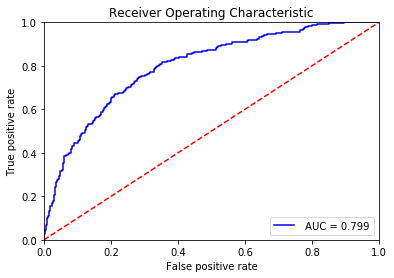

In [283]:
plt.title('Receiver Operating Characteristic') 
plt.plot( fpr, tpr, 'b', label =' AUC = %0.3f' % roc_auc) 
plt.legend( loc ='lower right') 
plt.plot([ 0, 1], [0, 1], 'r--') 
plt.xlim([ 0.0, 1.0]) 
plt.ylim([ 0.0, 1.0]) 
plt.ylabel('True positive rate') 
plt.xlabel('False positive rate') 
plt.show()

__Plockar ut sannolikheten för vinst och skapar en ny dataframe som håller y, score och omgång och lopp ==> lägger tillbaks mot validate__

In [284]:
df_predict = pd.DataFrame({'Score': predict[:,1]})

In [285]:
df_predict.shape

(3097, 1)

In [286]:
validate.shape

(3097, 30)

In [287]:
type(validate)

pandas.core.frame.DataFrame

In [288]:
df_analys = pd.concat([validate.reset_index(), df_predict], axis = 1)

In [289]:
df_analys.Datum.drop_duplicates().count()

38

In [290]:
df_analys.y.sum()

261

In [291]:
# Andelen vinnare som vi söker

df_analys.y.sum()/len(df_analys) * 100

8.427510494026476

In [292]:
df_analys.groupby('y').Score.mean()

y
0    0.074751
1    0.209981
Name: Score, dtype: float64

In [293]:
df_analys.Score.describe()

count    3097.000000
mean        0.086148
std         0.106647
min         0.009871
25%         0.014233
50%         0.036449
75%         0.124677
max         0.511805
Name: Score, dtype: float64

In [ ]:
# För varje omgång beräkna hur många hästar med Score >= 0.119471 som vinner. Vill se en jämn fördelning 

In [295]:
df_analys[df_analys.Score >=  0.124677].groupby('Datum').y.sum()

Datum
2017-08-16    5
2017-08-19    2
2017-09-02    4
2017-09-03    5
2017-09-30    6
2017-12-09    5
2018-01-13    7
2018-01-27    7
2018-01-28    5
2018-03-03    3
2018-03-29    5
2018-04-14    4
2018-04-21    6
2018-05-19    6
2018-08-22    2
2018-09-01    5
2018-09-02    6
2018-09-29    5
2018-10-28    7
2018-12-08    5
2018-12-22    5
2018-12-23    4
2019-02-02    4
2019-03-16    5
2019-03-30    4
2019-03-31    5
2019-04-19    4
2019-04-21    5
2019-08-11    4
2019-08-21    4
2019-08-24    4
2019-09-01    5
2019-09-07    5
2019-09-08    4
2019-09-29    5
2019-10-12    2
2019-11-02    0
2019-11-09    5
Name: y, dtype: int64

In [294]:
df_analys[df_analys.Score >=   0.124677].y.sum()/df_analys.y.sum()

0.6666666666666666

__Sorterar fallande på score och plockar 10%, hur stor är andelen vinnare då?__

In [296]:
df_analys_sorted = df_analys.sort_values('Score', ascending = False)

In [297]:
df_analys_sorted.iloc[:100,:].y.sum()/len(df_analys_sorted.iloc[:100,:]) * 100

40.0

In [298]:
# Gain - hur mycket bättre modellen är en slumpen i översta decilen

(df_analys_sorted.iloc[:100,:].y.sum()/len(df_analys_sorted.iloc[:100,:]) * 100) / (df_analys.y.sum()/len(df_analys) * 100)

4.746360153256705

__Nu vill vi för varje omgång idenfiera de lopp med högst sannolikhet att ha vinnarna i VNUM 1-3. Vi måste sammanfatta scoren för varje häst__

In [299]:
df_analys.Datum.drop_duplicates().count()

38

In [300]:
datum_list = list(set(df_analys.Datum.tolist()))

In [301]:
omg_list = []

for date in datum_list:
    df = df_analys[df_analys.Datum == date]
    i = 0
    for lopp in [1,2,3,4,5,6,7]:
        ldf = df[df.Lopp == lopp]
        ldf = ldf.sort_values('Score', ascending = False)
        vin = ldf.iloc[:3].y.sum()
        i = i + vin
    omg_list.append(i)
    

In [302]:
omg_list

[5,
 4,
 4,
 5,
 5,
 5,
 5,
 3,
 7,
 6,
 6,
 4,
 5,
 5,
 5,
 4,
 6,
 4,
 2,
 6,
 0,
 7,
 6,
 2,
 4,
 4,
 5,
 4,
 5,
 3,
 5,
 5,
 5,
 5,
 4,
 4,
 5,
 7]

In [303]:
df_analys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3097 entries, 0 to 3096
Data columns (total 33 columns):
Datum          3097 non-null datetime64[ns]
Lopp           3097 non-null int64
VSVLP          3097 non-null float64
VLPB           3097 non-null float64
E_N            3097 non-null float64
VPK_SUM_ORD    3097 non-null float64
GRUPP          3097 non-null int64
Ex_R           3097 non-null float64
ToR            3097 non-null float64
SVLP           3097 non-null float64
E_P            3097 non-null float64
VPK_SUM        3097 non-null float64
y              3097 non-null int64
Startsatt      3097 non-null int64
E_U            3097 non-null float64
Arstid         3097 non-null int64
SVLPB          3097 non-null float64
TK_R           3097 non-null float64
E_R            3097 non-null float64
R_R            3097 non-null float64
P_R            3097 non-null float64
VSVLPB         3097 non-null float64
VLP            3097 non-null float64
VPN_SUM        3097 non-null float64
SP_R    

### Scorar varje omgång fallande och skickar score och E_P_Num samt Y in till Leif

In [304]:
grouped = df.groupby(['Datum'])

In [305]:
omg_list = []

for date in datum_list:
    df = df_analys[df_analys.Datum == date]
    df = df[['Datum','Score','y','E_P_Num']].sort_values('Score', ascending = False)
    omg_list.append(df)
    

In [306]:
export_df = pd.concat(omg_list)

In [98]:
export_df.to_excel('Validation_model.xlsx')

In [307]:
# Vi väljer de 20 högst scorade hästarna och ser hur många vinnare i varje omgång vi får

ylist = []
for date in datum_list:
    df = df_analys[df_analys.Datum == date]
    df = df[['Datum','Score','y','E_P_Num']].sort_values('Score', ascending = False)
    vin = round((df.iloc[:20].y.sum()/7) * 100).astype('int')
    ylist.append(vin)


In [308]:
ylist

[57,
 57,
 57,
 71,
 71,
 71,
 71,
 43,
 100,
 86,
 71,
 57,
 71,
 71,
 71,
 57,
 86,
 57,
 29,
 86,
 0,
 100,
 86,
 29,
 57,
 57,
 57,
 57,
 57,
 29,
 71,
 57,
 57,
 71,
 57,
 57,
 71,
 100]

### Retry 1

In [337]:
df_ret1 = pd.read_excel('RetryUffeR2020-04-12.xlsx')

In [338]:
df_ret1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 36 columns):
Datum          87 non-null datetime64[ns]
Arstid         87 non-null int64
Distans        87 non-null int64
Startsatt      87 non-null int64
Lopp           87 non-null int64
Plac           87 non-null int64
Hast           87 non-null int64
V75PROC        87 non-null float64
V_ODDS         87 non-null float64
GRUPP          87 non-null int64
VLP            87 non-null float64
VNUM           87 non-null int64
SVLP           87 non-null float64
VSVLP          87 non-null float64
VPN_SUM        87 non-null float64
VPN_SUM_ORD    87 non-null int64
VPK_SUM        87 non-null float64
VPK_SUM_ORD    87 non-null int64
VLPB           87 non-null float64
SVLPB          87 non-null float64
VSVLPB         87 non-null float64
E_P            87 non-null float64
E_P_Num        87 non-null int64
E_N            87 non-null float64
E_R            87 non-null float64
E_U            87 non-null float64
G_

In [339]:
# Kör pipeline på nytt data 

predict = pipe_model.predict_proba(df_ret1[cols])

In [340]:
# Lägger tillbaks Score för vinst på indata och skickar tillbkas till Leif

In [341]:
predict_retry1 = pd.DataFrame({'Score': predict[:,1]})

In [342]:
df_out_rettry1 = pd.concat([df_ret1[['Datum','Hast','Lopp','VNUM','E_P_Num']], predict_retry1], axis = 1)

In [343]:
df_out_rettry1_1 = df_out_rettry1.sort_values('Score', ascending = False).iloc[:21,:]

In [344]:
df_out_rettry1_1

,Datum,Hast,Lopp,VNUM,E_P_Num,Score
23,2020-04-12,14,3,1,6,0.452415
63,2020-04-12,5,6,1,1,0.412258
11,2020-04-12,5,2,1,7,0.401840
0,2020-04-12,10,1,1,4,0.400084
37,2020-04-12,10,4,1,2,0.376160
52,2020-04-12,4,5,1,3,0.371412
75,2020-04-12,4,7,1,5,0.350549
53,2020-04-12,3,5,2,3,0.211834
39,2020-04-12,12,4,3,2,0.207485
12,2020-04-12,10,2,2,7,0.196414


In [346]:
df_out_rettry1_1.VNUM.value_counts()

3    7
2    7
1    7
Name: VNUM, dtype: int64

In [347]:
cols

['VSVLP',
 'VLPB',
 'E_N',
 'VPK_SUM_ORD',
 'GRUPP',
 'Ex_R',
 'ToR',
 'SVLP',
 'E_P',
 'VPK_SUM',
 'Startsatt',
 'E_U',
 'Arstid',
 'SVLPB',
 'TK_R',
 'E_R',
 'R_R',
 'P_R',
 'VSVLPB',
 'VLP',
 'VPN_SUM',
 'SP_R',
 'T_R',
 'G_R',
 'VPN_SUM_ORD',
 'Distans',
 'E_P_Num',
 'Ts_R',
 'A_R']